# CryoVesNet semi automatic pipeline
disable tensorflow thousands of messages and select a GPU that is hopefully not used


In [1]:
import warnings
import os
warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
import cryovesnet
import numpy as np
import napari
import tqdm
import skimage
import matplotlib.pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
dataset_directory = dataset_directory = "/home/bzuber/projects/cryovesnet/102_4e_trimmed/"

In [4]:
pl = cryovesnet.Pipeline(dataset_directory)
pl.setup_cryovesnet_dir()


CryoVesNet Pipeline: the pipeline is created for /home/bzuber/projects/cryovesnet/102_4e_trimmed
CryoVesNet Pipeline: setting up cryovesnet directory


## Run the deep vesicle? 
if you haven't ran the next cell for this dataset, then do it (you'll need a GPU);

otherwise skip it and run the next one.

In [5]:
pl.run_deep_at_multiple_rescale()

  0%|          | 0/8 [00:00<?, ?it/s]

CryoVesNet pipeline: run_deep_at_multiple_rescale - rescale = 0.35078625770131494
CryoVesNet pipeline: Running unet segmentation if there are less than 7 file in ./deep directory



100%|██████████| 5/5 [00:09<00:00,  1.84s/it]

finding global threshold on unet mask: 100%|██████████| 20/20 [00:01<00:00, 12.39it/s]

reorganizing labels after label clean up: 100%|██████████| 2/2 [00:00<00:00, 56.50it/s]


CryoVesNet Pipeline: zooming the unet mask
last output array name: deep_mask
last mrc file saved : cryovesnet/Dummy_102.rec_zoomed_mask.mrc


 12%|█▎        | 1/8 [00:33<03:55, 33.69s/it]

CryoVesNet pipeline: run_deep_at_multiple_rescale - rescale = 0.40089858023007424
CryoVesNet pipeline: Running unet segmentation if there are less than 7 file in ./deep directory



100%|██████████| 6/6 [00:12<00:00,  2.02s/it]

finding global threshold on unet mask: 100%|██████████| 20/20 [00:03<00:00,  5.85it/s]

reorganizing labels after label clean up: 100%|██████████| 3/3 [00:00<00:00, 26.45it/s]


CryoVesNet Pipeline: zooming the unet mask
last output array name: deep_mask
last mrc file saved : cryovesnet/Dummy_102.rec_zoomed_mask.mrc


 38%|███▊      | 3/8 [01:56<03:21, 40.30s/it]

CryoVesNet pipeline: run_deep_at_multiple_rescale - rescale = 0.5011232252875928
CryoVesNet pipeline: Running unet segmentation if there are less than 7 file in ./deep directory



100%|██████████| 7/7 [00:21<00:00,  3.10s/it]

finding global threshold on unet mask: 100%|██████████| 20/20 [00:04<00:00,  4.34it/s]

reorganizing labels after label clean up: 100%|██████████| 5/5 [00:00<00:00, 21.23it/s]


CryoVesNet Pipeline: zooming the unet mask
last output array name: deep_mask
last mrc file saved : cryovesnet/Dummy_102.rec_zoomed_mask.mrc


 50%|█████     | 4/8 [02:48<02:58, 44.74s/it]

CryoVesNet pipeline: run_deep_at_multiple_rescale - rescale = 0.5512355478163521
CryoVesNet pipeline: Running unet segmentation if there are less than 7 file in ./deep directory



100%|██████████| 8/8 [00:29<00:00,  3.63s/it]

finding global threshold on unet mask: 100%|██████████| 20/20 [00:06<00:00,  3.28it/s]

reorganizing labels after label clean up: 100%|██████████| 6/6 [00:00<00:00, 15.47it/s]


CryoVesNet Pipeline: zooming the unet mask
last output array name: deep_mask
last mrc file saved : cryovesnet/Dummy_102.rec_zoomed_mask.mrc


 62%|██████▎   | 5/8 [03:49<02:32, 50.85s/it]

CryoVesNet pipeline: run_deep_at_multiple_rescale - rescale = 0.6013478703451114
CryoVesNet pipeline: Running unet segmentation if there are less than 7 file in ./deep directory



100%|██████████| 9/9 [00:40<00:00,  4.50s/it]

finding global threshold on unet mask: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s]

reorganizing labels after label clean up: 100%|██████████| 19/19 [00:01<00:00, 11.68it/s]


CryoVesNet Pipeline: zooming the unet mask
last output array name: deep_mask
last mrc file saved : cryovesnet/Dummy_102.rec_zoomed_mask.mrc


 75%|███████▌  | 6/8 [05:07<02:00, 60.08s/it]

CryoVesNet pipeline: run_deep_at_multiple_rescale - rescale = 0.6514601928738706
CryoVesNet pipeline: Running unet segmentation if there are less than 7 file in ./deep directory



100%|██████████| 9/9 [00:45<00:00,  5.06s/it]

finding global threshold on unet mask: 100%|██████████| 20/20 [00:09<00:00,  2.00it/s]

reorganizing labels after label clean up: 100%|██████████| 35/35 [00:03<00:00,  9.20it/s]


CryoVesNet Pipeline: zooming the unet mask
last output array name: deep_mask
last mrc file saved : cryovesnet/Dummy_102.rec_zoomed_mask.mrc


 88%|████████▊ | 7/8 [06:37<01:09, 69.69s/it]

CryoVesNet pipeline: run_deep_at_multiple_rescale - rescale = 0.7015725154026299
CryoVesNet pipeline: Running unet segmentation if there are less than 7 file in ./deep directory



100%|██████████| 10/10 [01:00<00:00,  6.04s/it]

finding global threshold on unet mask: 100%|██████████| 20/20 [00:12<00:00,  1.65it/s]

reorganizing labels after label clean up: 100%|██████████| 7/7 [00:00<00:00,  7.33it/s]


CryoVesNet Pipeline: zooming the unet mask
last output array name: deep_mask
last mrc file saved : cryovesnet/Dummy_102.rec_zoomed_mask.mrc


100%|██████████| 8/8 [08:23<00:00, 62.91s/it]


In [9]:
pl.set_array('deep_mask')

'deep_mask'

## label statistics
We can select the best initial threshold for making spheres based on statistics

In [7]:
diameter_dict = {}
for threshold in tqdm.tqdm(np.arange(0.9,1,0.01)):
    image_label = skimage.morphology.label(pl.deep_mask>threshold)
    area = skimage.measure.regionprops_table(image_label, properties=('bbox_area',))['bbox_area']
    diameter_dict[threshold] = area**(1/3)/pl.voxel_size

100%|██████████| 10/10 [00:30<00:00,  3.07s/it]


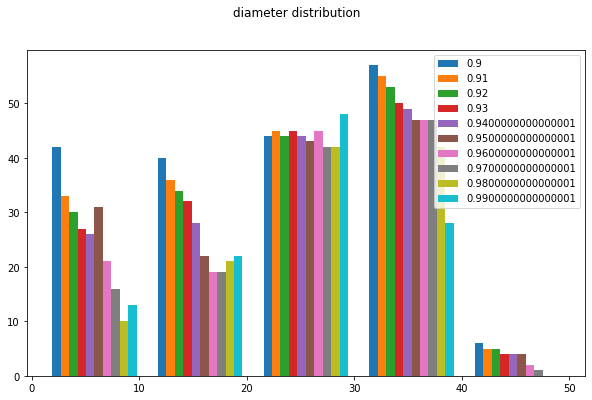

In [8]:
fig = plt.figure(figsize=(10,6))
fig.suptitle("diameter distribution")
_ = plt.hist(list(diameter_dict.values())[::1], label=list(diameter_dict.keys())[::1],bins=5)
_ = plt.legend()

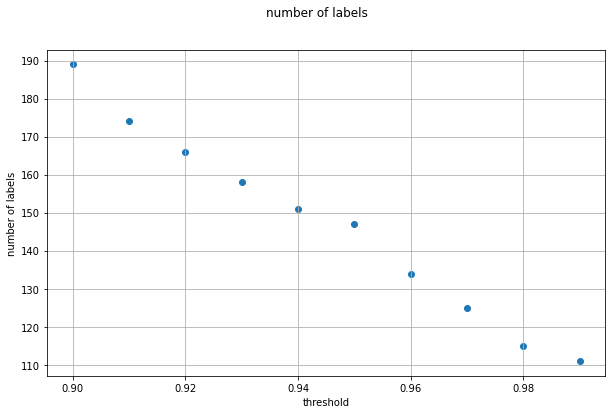

In [9]:
fig = plt.figure(figsize=(10,6))
fig.suptitle("number of labels")
plt.xlabel("threshold")
plt.ylabel("number of labels")
plt.grid()
plt.scatter(x=list(diameter_dict.keys()), y=[len(v) for v in list(diameter_dict.values())])

## How to chose the optimal starting threshold
The higher the threshold, the lower the false positive but the higher the false negative. 
There is no single best threshold. 

On our test dataset, a threshold of 0.96 found most of the vesicles and gave only few false positives.

In [13]:
pl.label_vesicles_simply(threshold=0.96)

CryoVesNet Pipeline: running label_vesicles_simply
CryoVesNet Pipeline: restricting labels to segmentation region
last output array name: deep_mask
last mrc file saved : cryovesnet/Dummy_102.rec_zoomed_mask.mrc


Expanding labels until none is too small:  17%|█▋        | 1/6 [00:08<00:42,  8.43s/it]


last output array name: deep_labels
last mrc file saved : cryovesnet/Dummy_102.rec_deep_labels.mrc


In [14]:
pl.make_spheres()

CryoVesNet Pipeline: Making vesicles spherical.


fitting sphere to vesicles: 100%|██████████| 102/102 [00:03<00:00, 28.93it/s]


last output array name: sphere_labels
last mrc file saved : cryovesnet/Dummy_102.rec_sphere.mrc


### optional visualization of deep_labels and sphere_labels

In [12]:
pl.visualization_old_new('deep_labels','sphere_labels')

CryoVesNet Pipeline: visualizing two sets of labels. To continue, close napari window


### Outlier detection
Detect outliers using multivariate statistics on 3 parameters of the detected spheres. We get a list of the most deviating labels (those that have a mahalanobis distance larger than min_mahalanobis_distance). So far the default min_mahalanobis_distance of 2.0 is good. If the red line on the plot does not include enough outliers to your liking, then use a lower value (optional parameter of pl.identify_sphere_outliers).

array([[<AxesSubplot:title={'center':'thickness'}>,
        <AxesSubplot:title={'center':'density'}>],
       [<AxesSubplot:title={'center':'radius'}>,
        <AxesSubplot:title={'center':'mahalanobis'}>]], dtype=object)

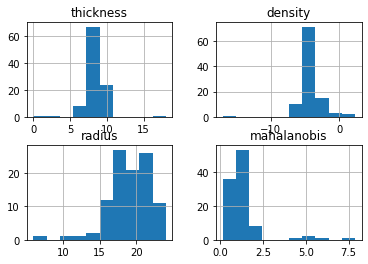

In [15]:
pl.sphere_df.hist()

       thickness    density  radius           center  mahalanobis
label                                                            
5             10  -4.035897      14   [50, 787, 388]     2.003841
42             6  -2.586101      14  [112, 679, 337]     2.096748
59            10  -2.148012      15  [127, 896, 334]     2.104975
45             6  -0.507260      19  [112, 355, 455]     2.285350
55             8   2.155889      12  [122, 444, 477]     4.115182
1              0  -1.044170      21   [29, 551, 290]     4.999518
56             2   2.269504      10  [118, 396, 185]     5.389390
8             18  -0.844111      17   [40, 387, 449]     6.062049
95             8 -16.954545       6  [190, 726, 322]     7.875317
You should inspect the labels that have a high mahalanobis distance as they are the likeliest to be wrongly segmented


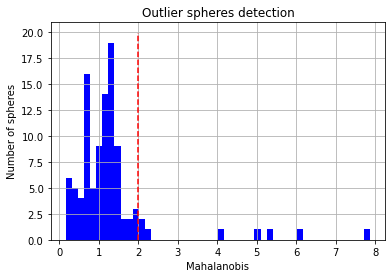

In [16]:
pl.identify_spheres_outliers(min_mahalanobis_distance=2)

In [17]:
pl.fix_spheres_interactively()

last output array name: mancorr_labels
last mrc file saved : cryovesnet/Dummy_102.rec_mancorr.mrc


In [10]:
pl.visualization_old_new('sphere_labels','mancorr_labels')

CryoVesNet Pipeline: visualizing two sets of labels. To continue, close napari window


It is recommended to compute a new sphere dataframe (which is one of the steps of make_spheres()) in order to identify remaining outliers.

In [18]:
pl.compute_sphere_dataframe('mancorr_labels')

fitting sphere to vesicles: 100%|██████████| 97/97 [00:01<00:00, 67.51it/s] 


array([[<AxesSubplot:title={'center':'thickness'}>,
        <AxesSubplot:title={'center':'density'}>],
       [<AxesSubplot:title={'center':'radius'}>,
        <AxesSubplot:title={'center':'mahalanobis'}>]], dtype=object)

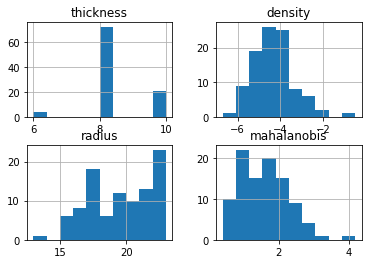

In [19]:
pl.sphere_df.hist()

       thickness   density  radius           center  mahalanobis
label                                                           
20            10 -3.760571      22   [89, 676, 373]     2.054252
102           10 -3.196447      17  [208, 864, 360]     2.111425
99            10 -5.037697      22  [211, 354, 398]     2.136110
34             8 -6.061285      17  [107, 367, 137]     2.143581
93            10 -5.292155      22  [200, 387, 188]     2.249398
16            10 -2.860914      17   [83, 668, 452]     2.253671
42             8 -2.586101      15  [112, 679, 337]     2.270740
65             8 -5.957868      16  [145, 286, 320]     2.308122
28            10 -2.647040      20  [104, 156, 431]     2.316948
30             8 -3.031496      23  [108, 723, 337]     2.355147
5              8 -4.035897      13   [50, 787, 388]     2.455283
19            10 -5.667855      22   [92, 247, 318]     2.460414
63             6 -4.629148      18  [140, 314, 458]     2.470970
27             6 -4.35632

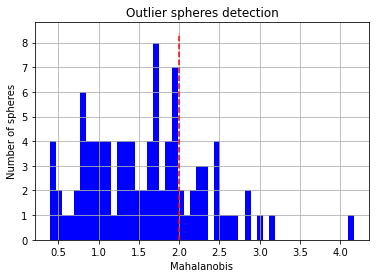

In [20]:
pl.identify_spheres_outliers()

In [22]:
pl.fix_spheres_interactively('mancorr_labels')

last output array name: mancorr_labels
last mrc file saved : cryovesnet/Dummy_102.rec_mancorr.mrc


In [23]:
pl.compute_sphere_dataframe('mancorr_labels')

fitting sphere to vesicles: 100%|██████████| 99/99 [00:01<00:00, 66.62it/s] 


       thickness   density  radius           center  mahalanobis
label                                                           
104            8 -4.117820      14  [203, 367, 289]     2.014522
20            10 -3.760571      22   [89, 676, 373]     2.038021
102           10 -3.196447      17  [208, 864, 360]     2.041389
34             8 -6.061285      17  [107, 367, 137]     2.140232
99            10 -5.037697      22  [211, 354, 398]     2.150193
16            10 -2.860914      17   [83, 668, 452]     2.176700
42             8 -2.586101      15  [112, 679, 337]     2.220614
28            10 -2.647040      20  [104, 156, 431]     2.265529
93            10 -5.292155      22  [200, 387, 188]     2.268161
65             8 -5.957868      16  [145, 286, 320]     2.298796
30             8 -3.031496      23  [108, 723, 337]     2.368238
5              8 -4.035897      13   [50, 787, 388]     2.397205
105           10 -2.431980      17  [186, 302, 403]     2.414010
63             6 -4.62914

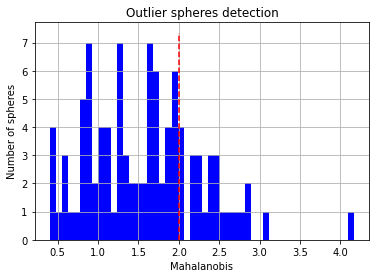

In [24]:
pl.identify_spheres_outliers()

In [14]:
pl.visualization_old_new('sphere_labels','mancorr_labels')

CryoVesNet Pipeline: visualizing two sets of labels. To continue, close napari window


In [25]:
pl.make_full_modfile()
pl.make_full_label_file()
pl.initialize_pyto()

CryoVesNet Pipeline: making full mod file
rearranged labels
last output array name: final_vesicle_labels
last mrc file saved : cryovesnet/Dummy_102.rec_final_vesicle_labels.mrc
full model file saved to cryovesnet/full_cryovesnet.mod
CryoVesNet Pipeline: making full label file
saved labels to cryovesnet/labels.mrc
CryoVesNet Pipeline: setting up pyto folder
/home/bzuber/projects/cryovesnet/102_4e_trimmed/pyto exists. Skipping pyto file creation. To force reinitialization of pyto folder, set overwrite to True
